In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
import geopandas as gpd
import pandas as pd
import numpy as np
from datetime import timedelta, datetime

from fiona.crs import from_epsg
import shapely
from shapely.geometry import *


from geopy.distance import vincenty

#### Shape file/ for presentation

In [2]:
# nybb = gpd.read_file('nybb_17c/nybb.shp')

In [3]:
# Get the route files
# import subprocess
# subprocess.run("powershell Invoke-WebRequest {} -OutFile {}".format('http://data.mytransit.nyc.s3.amazonaws.com/gtfs/2015/gtfs_nyct_bus_20150103.zip', 'gtfs_nyct_bus_20150103.zip'), shell=True)
# subprocess.run("powershell Invoke-WebRequest {} -OutFile {}".format('http://data.mytransit.nyc.s3.amazonaws.com/bus_time/2015/2015-01/bus_time_20150128.csv.xz', 'bus_time_20150128.csv.xz'), shell=True)
# subprocess.run("powershell Invoke-WebRequest {} -OutFile {}".format('http://data.mytransit.nyc.s3.amazonaws.com/bus_time/2015/2015-01/bus_time_20150129.csv.xz', 'bus_time_20150129.csv.xz'), shell=True)


# import zipfile
# import lzma
# zip = zipfile.ZipFile('gtfs_nyct_bus_20150103.zip')
# zip.extractall()

In [4]:
def convert_to_int64(row):
    try:
        return np.int64(row)
    except ValueError:
        return np.nan

def utc_to_est(row):
    try:
        return row - timedelta(hours=5)
    except:
        raise

csv_f = pd.read_csv
archive = pd.concat([csv_f("bus_time_20150128.csv"),
                     csv_f("bus_time_20150129.csv")])        
        
trips = pd.read_csv("trips.txt")
stops = pd.read_csv("stops.txt")
schedules = pd.read_csv("stop_times.txt")

/home/sunglyoung/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
archive.next_stop_id = archive.next_stop_id.apply(convert_to_int64)

In [6]:
#query and clean
live_archive = archive[archive.block_assigned > 0] # "assigned" to a route
today = live_archive[live_archive.service_date == 20150128] # due to time shift we get some dates in 1/27 and 1/29
#throw away trips with <15 reports
good_trips_only = today.groupby(today.trip_id).filter(lambda group: len(group) > 15)

#write this as our "clean" dataset
good_trips_only.to_csv("realtime.csv")

#merged dataframe with both 
partial = good_trips_only.merge(trips, on='trip_id') 
df = partial.merge(stops, left_on="next_stop_id", right_on="stop_id")

In [7]:
# Select one bus route 
pd.options.display.max_columns = None
m15_only = df[df.route_id.str.contains("M15")].reset_index()
m15_only["timestamp"] = pd.to_datetime(m15_only["timestamp"])

In [8]:
m15_reg = m15_only[m15_only.trip_id.str.contains("M15")].reset_index()
m15_sbs = m15_only[m15_only.trip_id.str.contains("SBS")].reset_index()

In [9]:
print('The number of regular M15 buses over 48 hours =',len(m15_reg.trip_id.unique()))
print('The number of express M15 buses over 48 hours =',len(m15_sbs.trip_id.unique()))

('The number of regular M15 buses over 48 hours =', 257)
('The number of express M15 buses over 48 hours =', 335)


## Analysis

In [10]:
def split_direction(df):
    df_1 = df[df.direction_id == 1]
    
    df_1 = df_1[df_1.trip_id == df_1.trip_id.values[0]]
    
    df_1.sort_values('timestamp')
    
    df_0 = df[df.direction_id == 0]
    
    df_0 = df_0[df_0.trip_id == df_0.trip_id.values[0]]
      
    df_0 = df_0.sort_values('timestamp')
    return (df_1, df_0)


#### It will split DataFrame into two bus's direction

In [11]:
m15_reg_1, m15_reg_0 = split_direction(m15_reg)

In [12]:
m15_sbs_1, m15_sbs_0 = split_direction(m15_sbs)

#### The typical NYC block length is 0.05 miles ~ 100 meters

## We need 1 and 2 for each direction!!!!

In [13]:
# >>> from geopy.distance import vincenty
def finding_busstop(df1_regular, df2_express, meters): # df1 is regular, df2 is express, meters is threshold
    

    #### cleaning filtered data by stop_name             for sharing stop in meters
    
    clean_df1 = df1_regular.drop_duplicates(subset = 'stop_name', keep = 'first').reset_index(drop = True)
    clean_df2 = df2_express.drop_duplicates(subset = 'stop_name', keep = 'first').reset_index(drop = True)
    
    #### finding shared busstops
    regular = []
    express = []

    
    for j in range(len(clean_df1)):
        sStop1 = (clean_df1.latitude[j], clean_df1.longitude[j])
    
        for i in range(len(clean_df2)):
            rStop1 = (clean_df2.latitude[i], clean_df2.longitude[i])
            dist = (vincenty(rStop1, sStop1).meters)
        
            if(dist <= meters):
            
                regular.append(j)
                express.append(i)
    ##### making a bus stop panda frame
    cols = {'regular_stop' : regular, 'express_stop' : express}
    EStops = pd.DataFrame(cols)
    EStops.drop_duplicates(subset = 'express_stop', keep = 'first', inplace= True)
    regular = EStops.regular_stop
    express = EStops.express_stop
    
    ###### Finding the stop name  
    Share_Stop = clean_df1.iloc[regular,20].reset_index(drop = True)
    Share_eStop = clean_df2.iloc[express,20].reset_index(drop = True)
        
    
    return (Share_Stop, Share_eStop)




#### Finding Share_Stop and Share_eStop for analysis

In [14]:
Share_Stop, Share_eStop  = finding_busstop(m15_reg_1, m15_sbs_1, 100)

In [15]:
Share_Stop

0              2 AV/E 125 ST
1              2 AV/E 116 ST
2               2 AV/E 96 ST
3               2 AV/E 66 ST
4               2 AV/E 46 ST
5               2 AV/E 39 ST
6               2 AV/E 31 ST
7          ALLEN ST/CANAL ST
8     MADISON ST/ST JAMES PL
9         WATER ST/MAIDEN LA
10    WATER ST/GOUVERNEUR LA
Name: stop_name, dtype: object

In [16]:
Share_eStop

0               2 AV/E 125 ST
1               2 AV/E 106 ST
2               2 AV/E 100 ST
3                2 AV/E 57 ST
4                2 AV/E 42 ST
5                2 AV/E 34 ST
6                2 AV/E 28 ST
7     MADISON ST/CATHERINE ST
8          PEARL ST/FULTON ST
9            WATER ST/WALL ST
10       SOUTH FERRY/TERMINAL
Name: stop_name, dtype: object

In [17]:
def r_anaysis(df, Share_Stop):
### cleaning the clean_df1 and clean_df2 for only sharing bus_stop
    clean_df1 = df.drop_duplicates(subset = 'stop_name', keep = 'first').reset_index(drop = True)
    SR = clean_df1[clean_df1.stop_name.isin(Share_Stop)].reset_index(drop = True) ## Sharing regular bus stop
#     SE = clean_df2[clean_df2.stop_name.isin(Share_eStop)].reset_index(drop = True) ## sharing expresss bus stop
#     df_join = SR.join(SE, lsuffix = '_regular', rsuffix = '_express')
    SR.dropna(axis = 0)
    
    
    #### calculating speed
#     express_speed = []
    regular_speed = []

    for i in range(len(SR)-1):
##             for SBS bus
#             ed = df_join.dist_along_route_express.values.astype(float)[i+1] \
#             - df_join.dist_along_route_express.values.astype(float)[i]
        
#             et = (df_join.timestamp_express[i+1] - df_join.timestamp_express[i]).seconds
#             express_speed.append(((ed/1000 * 0.625) /et) * 3600)
            
            # Regular bus

            rd = SR.dist_along_route.values.astype(float)[i+1] \
            - SR.dist_along_route.values.astype(float)[i]
        
            rt = (SR.timestamp[i+1] - SR.timestamp[i]).seconds
            regular_speed.append(((rd/1000 * 0.625) / rt) * 3600)
    
    ### making average_speed data frame
 
    cols = {'regular_mph' : regular_speed}
    mph = pd.DataFrame(cols)
    df_regular =  SR.join(mph)
    return (df_regular)
    
    

### regular _ Analysis

In [18]:
r_anaysis(m15_reg, Share_Stop )

,level_0,index,timestamp,vehicle_id,latitude,longitude,bearing,progress,service_date,trip_id,block_assigned,next_stop_id,dist_along_route,dist_from_stop,route_id,service_id,trip_headsign,direction_id,shape_id,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,regular_mph
0,0,161849,2015-01-28 05:23:55,6786,40.803310,-73.933166,233.93,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,401738,180.23,108.89,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401738,2 AV/E 125 ST,NaN,40.802494,-73.933891,NaN,NaN,0,NaN,13.153500
1,1079,162928,2015-01-28 05:26:00,6786,40.796702,-73.937992,234.01,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,401741,910.98,0,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401741,2 AV/E 116 ST,NaN,40.796745,-73.938095,NaN,NaN,0,NaN,23.098443
2,1989,163838,2015-01-28 05:28:39,6786,40.787300,-73.944873,234.10,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,803182,2543.27,437.1,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,803182,2 AV/E 96 ST,NaN,40.783901,-73.947472,NaN,NaN,0,NaN,10.896205
3,5264,167113,2015-01-28 05:37:03,6786,40.765665,-73.960653,233.73,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,401762,4984.02,129.36,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401762,2 AV/E 66 ST,NaN,40.764698,-73.961517,NaN,NaN,0,NaN,11.100024
4,8226,170075,2015-01-28 05:42:17,6786,40.754562,-73.968748,233.75,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,401769,6533.09,267.76,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401769,2 AV/E 46 ST,NaN,40.752502,-73.970398,NaN,NaN,0,NaN,10.894075
5,9509,171358,2015-01-28 05:44:24,6786,40.749309,-73.972581,233.65,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,401772,7148,215.26,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401772,2 AV/E 39 ST,NaN,40.747662,-73.973930,NaN,NaN,0,NaN,22.337930
6,10066,171915,2015-01-28 05:45:28,6786,40.744383,-73.976171,233.91,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,401775,7783.39,224.91,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401775,2 AV/E 31 ST,NaN,40.742668,-73.977577,NaN,NaN,0,NaN,10.968566
7,11976,174008,2015-01-28 05:57:42,6786,40.715803,-73.992260,242.87,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,401793,11361.58,115.08,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401793,ALLEN ST/CANAL ST,NaN,40.714863,-73.992836,NaN,NaN,0,NaN,8.596110
8,13304,175336,2015-01-28 06:01:25,6786,40.712002,-73.997490,186.23,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,903054,12213.55,163.8,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,903054,MADISON ST/ST JAMES PL,NaN,40.711884,-73.999428,NaN,NaN,0,NaN,8.854809
9,14181,176506,2015-01-28 06:05:08,6786,40.706194,-74.005945,215.39,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,401800,13091.16,33.61,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401800,WATER ST/MAIDEN LA,NaN,40.706055,-74.006317,NaN,NaN,0,NaN,15.996797


In [19]:
def e_anaysis(df, Share_eStop):
### cleaning the clean_df1 and clean_df2 for only sharing bus_stop
#     SR = clean_df1[clean_df1.stop_name.isin(Share_Stop)].reset_index(drop = True) ## Sharing regular bus stop
    clean_df2 = df.drop_duplicates(subset = 'stop_name', keep = 'first').reset_index(drop = True)
    SE = clean_df2[clean_df2.stop_name.isin(Share_eStop)].reset_index(drop = True) ## sharing expresss bus stop
#     df_join = SR.join(SE, lsuffix = '_regular', rsuffix = '_express')
#     df_join.dropna(axis = 0)
    
    
    #### calculating speed
    express_speed = []
#     regular_speed = []

    for i in range(len(SE)-1):
            # for SBS bus
            ed = SE.dist_along_route.values.astype(float)[i+1] \
            - SE.dist_along_route.values.astype(float)[i]
#         
            et = (SE.timestamp[i+1] - SE.timestamp[i]).seconds
            express_speed.append(((ed/1000 * 0.625) /et) * 3600)
            
#             # Regular bus

#             rd = df_join.dist_along_route_regular.values.astype(float)[i+1] \
#             - df_join.dist_along_route_regular.values.astype(float)[i]
        
#             rt = (df_join.timestamp_regular[i+1] - df_join.timestamp_regular[i]).seconds
#             regular_speed.append(((rd/1000 * 0.625) / rt) * 3600)
    
    ### making average_speed data frame
 
    cols = {'express_mph' : express_speed}
    mph = pd.DataFrame(cols)
    df_express = SE.join(mph)
    
    return(df_express)
    

In [20]:
e_anaysis(m15_sbs_1, Share_eStop)

,level_0,index,timestamp,vehicle_id,latitude,longitude,bearing,progress,service_date,trip_id,block_assigned,next_stop_id,dist_along_route,dist_from_stop,route_id,service_id,trip_headsign,direction_id,shape_id,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,express_mph
0,46,161895,2015-01-28 09:46:18,1273,40.803411,-73.933053,157.83,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,401738,180.23,126.16,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401738,2 AV/E 125 ST,NaN,40.802494,-73.933891,NaN,NaN,0,NaN,15.252405
1,5775,167624,2015-01-28 09:59:53,1273,40.765929,-73.960459,233.73,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,401765,5704.99,883.88,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401765,2 AV/E 57 ST,NaN,40.759022,-73.965652,NaN,NaN,0,NaN,12.336341
2,8471,170320,2015-01-28 10:03:33,1273,40.753940,-73.969202,233.99,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,401771,6911.21,566.84,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401771,2 AV/E 42 ST,NaN,40.749527,-73.972572,NaN,NaN,0,NaN,13.138977
3,12622,174654,2015-01-28 10:18:13,1273,40.715682,-73.992322,242.87,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,402112,12050.01,770.03,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,402112,MADISON ST/CATHERINE ST,NaN,40.712097,-73.997284,NaN,NaN,0,NaN,11.479615
4,13537,175846,2015-01-28 10:20:49,1273,40.711894,-73.998524,185.84,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,403590,12845.93,689.25,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,403590,PEARL ST/FULTON ST,NaN,40.707630,-74.003998,NaN,NaN,0,NaN,-0.139412
5,32731,791726,2015-01-28 10:05:38,1273,40.749435,-73.972489,233.65,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,401774,7548.97,632.22,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401774,2 AV/E 34 ST,NaN,40.744507,-73.976234,NaN,NaN,0,NaN,-0.155210
6,41974,1831899,2015-01-28 09:48:23,1273,40.796655,-73.938026,234.01,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,405347,1660.3,743.33,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,405347,2 AV/E 106 ST,NaN,40.790859,-73.942429,NaN,NaN,0,NaN,5.933452
7,42401,1832326,2015-01-28 09:51:32,1273,40.787643,-73.944623,233.82,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,903103,2158.71,96.08,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,903103,2 AV/E 100 ST,NaN,40.786915,-73.945244,NaN,NaN,0,NaN,13.515648
8,42884,1832809,2015-01-28 10:07:44,1273,40.744327,-73.976212,233.91,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,403525,7997.47,431.89,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,403525,2 AV/E 28 ST,NaN,40.740971,-73.978760,NaN,NaN,0,NaN,12.193013
9,43633,1833558,2015-01-28 10:23:58,1273,40.706453,-74.005577,214.75,0,20150128,OF_A5-Weekday-SDon-028500_SBS15_1,1,403754,13275.69,241.48,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,403754,WATER ST/WALL ST,NaN,40.705044,-74.007759,NaN,NaN,0,NaN,22.641786


In [21]:
def final_df(df_regular, df_express, Share_Stop = Share_Stop, Share_eStop = Share_eStop):

    my_a_0 = []

    for group in df_regular.groupby('trip_id'):
    
        a = r_anaysis(group[1], Share_Stop)
        my_a_0.append(a)
    my_df_r = pd.concat((my_a_0), axis=0)
    
    my_a_1 = []

    for group in df_express.groupby('trip_id'):
    
        a = e_anaysis(group[1], Share_eStop)
        my_a_1.append(a)
    my_df_e = pd.concat((my_a_1), axis=0)
    
    return (my_df_r, my_df_e)

In [22]:
my_df_r, my_df_e = final_df(m15_reg, m15_sbs)

In [23]:
my_df_r.shape

(1140, 29)

In [24]:
my_df_e.shape

(1981, 29)

In [25]:
testr = my_df_r[my_df_r.regular_mph > 0]
teste = my_df_e[my_df_e.express_mph > 0]

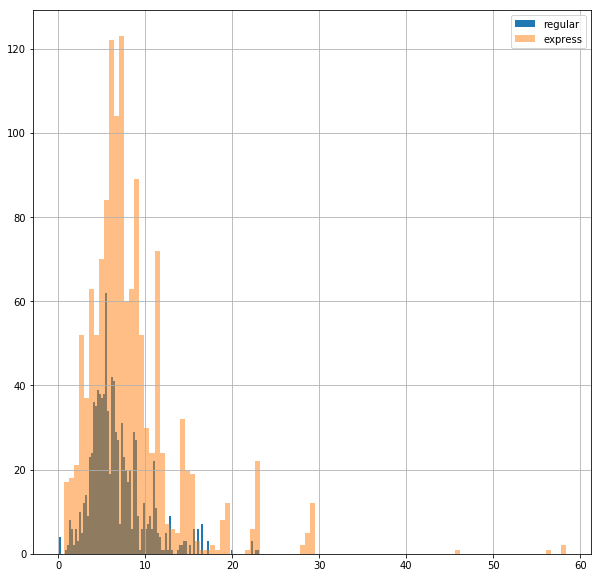

In [26]:
plt.figure(figsize=(10,10))
testr.regular_mph.hist(bins = 100, label = 'regular')
teste.express_mph.hist(bins = 100, alpha = 0.5, label = 'express')
plt.legend()

In [32]:
my_df_r[my_df_r.regular_mph < 1]

,level_0,index,timestamp,vehicle_id,latitude,longitude,bearing,progress,service_date,trip_id,block_assigned,next_stop_id,dist_along_route,dist_from_stop,route_id,service_id,trip_headsign,direction_id,shape_id,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,regular_mph
0,24,161873,2015-01-28 09:02:52,5622,40.803197,-73.932526,157.39,0,20150128,OH_A5-Weekday-SDon-024500_M15_6,1,401738,180.23,176.47,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401738,2 AV/E 125 ST,NaN,40.802494,-73.933891,NaN,NaN,0,NaN,0.019107
1,2081,163930,2015-01-28 14:02:28,5550,40.786320,-73.945588,233.68,0,20150128,OH_A5-Weekday-SDon-052100_M15_9,1,803182,2543.27,312.56,M15,OH_A5-Weekday-SDon,PIKE ST - DIVISION ST via 2 AV,1,M150352,803182,2 AV/E 96 ST,NaN,40.783901,-73.947472,NaN,NaN,0,NaN,0.064153
0,431,162280,2015-01-28 17:43:13,5640,40.803421,-73.933078,157.83,0,20150128,OH_A5-Weekday-SDon-078500_M15_14,1,401738,180.23,123.77,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401738,2 AV/E 125 ST,NaN,40.802494,-73.933891,NaN,NaN,0,NaN,0.915982
1,2330,164179,2015-01-28 22:59:17,5323,40.787175,-73.944963,234.10,0,20150128,OH_A5-Weekday-SDon-102600_M15_40,1,803182,2543.27,421.27,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,803182,2 AV/E 96 ST,NaN,40.783901,-73.947472,NaN,NaN,0,NaN,0.063818
2,2358,164207,2015-01-29 01:22:58,5257,40.785409,-73.946249,233.98,0,20150128,OH_A5-Weekday-SDon-116600_M15_46,1,803182,2543.27,197.05,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,803182,2 AV/E 96 ST,NaN,40.783901,-73.947472,NaN,NaN,0,NaN,0.064581


In [27]:
my_df_r[my_df_r.regular_mph > 20]

,level_0,index,timestamp,vehicle_id,latitude,longitude,bearing,progress,service_date,trip_id,block_assigned,next_stop_id,dist_along_route,dist_from_stop,route_id,service_id,trip_headsign,direction_id,shape_id,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,regular_mph
1,1079,162928,2015-01-28 05:26:00,6786,40.796702,-73.937992,234.01,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,401741,910.98,0,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401741,2 AV/E 116 ST,NaN,40.796745,-73.938095,NaN,NaN,0,NaN,23.098443
5,9509,171358,2015-01-28 05:44:24,6786,40.749309,-73.972581,233.65,0,20150128,OH_A5-Weekday-SDon-002000_M15_2,1,401772,7148,215.26,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401772,2 AV/E 39 ST,NaN,40.747662,-73.973930,NaN,NaN,0,NaN,22.337930
4,9510,171359,2015-01-28 06:29:29,3904,40.748376,-73.973258,233.77,0,20150128,OH_A5-Weekday-SDon-006000_M15_3,1,401772,7148,96.87,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401772,2 AV/E 39 ST,NaN,40.747662,-73.973930,NaN,NaN,0,NaN,22.692500
5,9513,171362,2015-01-28 07:23:23,6702,40.748800,-73.972951,234.21,0,20150128,OH_A5-Weekday-SDon-012000_M15_1,1,401772,7148,150.68,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401772,2 AV/E 39 ST,NaN,40.747662,-73.973930,NaN,NaN,0,NaN,22.337930
3,9516,171365,2015-01-28 09:14:27,5643,40.747995,-73.973537,233.77,0,20150128,OH_A5-Weekday-SDon-023000_M15_5,1,401772,7148,48.43,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,401772,2 AV/E 39 ST,NaN,40.747662,-73.973930,NaN,NaN,0,NaN,22.337930
6,13319,175351,2015-01-28 09:28:35,5643,40.711806,-73.999417,185.56,0,20150128,OH_A5-Weekday-SDon-023000_M15_5,1,903054,12213.55,0,M15,OH_A5-Weekday-SDon,SOUTH FERRY via 2 AV,1,M150351,903054,MADISON ST/ST JAMES PL,NaN,40.711884,-73.999428,NaN,NaN,0,NaN,20.052581


In [39]:
my_df_r.regular_mph.describe()

count    943.000000
mean       6.701798
std        3.233917
min        0.019107
25%        4.610111
50%        6.049927
75%        8.125357
max       23.098443
Name: regular_mph, dtype: float64

In [35]:
my_df_r.regular_mph.mean() + 2 * my_df_r.regular_mph.std()

13.169631272064187

In [36]:
  my_df_r.regular_mph.mean() - 2 * my_df_r.regular_mph.std()

0.2339648873825988

In [38]:
from scipy import stats
np.random.seed(12345678)

In [46]:
my_df_r.regular_mph

(1140,)

In [50]:
rvs1 = stats.norm.rvs(loc=6.702,scale=3.234,size=1140)
# >>> rvs2 = stats.norm.rvs(loc=5,scale=10,size=500)
# >>> stats.ttest_ind(rvs1,rvs2)
rvs2 = my_df_r.regular_mph

stats.ttest_ind(rvs1,rvs2, equal_var = False)

Ttest_indResult(statistic=nan, pvalue=nan)